# [Jigsaw Multilingual Toxic Comment Classification](https://www.kaggle.com/c/jigsaw-multilingual-toxic-comment-classification)

### Team: ZLC
### Members: Cheng Zeng
#### 05/15/2020

**Github blog links**:
- Start Blog: https://bit.ly/2ApfGZt

- Midway Blog: https://bit.ly/3byQBs8

- Final Blog: https://bit.ly/2zK7oLj

**Codes on github**: [code](https://github.com/cengc13/2040FinalProject)

**Kaggle entry for sklearn language models:**
[logistic regression and random forest models](https://www.kaggle.com/cengc13/jigsaw-logistic-regression-translated-data)


--------------------------------------------------------------------------------------------------------------

# Outline

* **1. Introduction**
* **2. Exploratory Data Analysis (EDA)**
    * The Dataset
    * WordCloud of Comments
    * Word and Sentence Count
* **3. The Baseline Language Model**
    * 3.1 Data Preprocess
    * 3.2 The Journey of a Comment
        * 3.2.1 Tokenizer
        * 3.2.2 Transformer
        * 3.2.3 Classifier
    * 3.3 Model Evaluation

* **4. Model Refinement**
    * 4.1 Increase the input size
    * 4.2 Hyperparameter tuning
    * 4.3 Data Augmentation
    * 4.4 Model Architectures
    * 4.5 Ensemble Prediction

* **5. Next Steps**

* **6. Acknowledgement**

--------------------------------------------------------------------------------------------------------------

# 1. Introduction

Thanks to the rapid development of deeping learning techniques and computational hardwares, NLP has been gaining its momentum in the past two decades. As believed by machine learning experts, NLP is experiencing a boom in the short-term future, same as computer vision once did.



Like the midterm project, this final project is also a [Kaggle competition](https://www.kaggle.com/c/jigsaw-multilingual-toxic-comment-classification). It is a natural language processing (NLP) project. I woule like to take this opportunity to learn more about deep learning, with emphasis on its application in NLP.

Taking advantage of Kaggle's TPU support, this competition aims to build multilingual models with English-only training data. The model will be tested on Wikipedia talk page comments in several other languages. It is supported by The Conversation AI team, which is funded by [Jigsaw](https://jigsaw.google.com/) and Google. 

Our goal is to take a comment text as input, and produces either 1(the comment is toxic) or 0 (the comment is non-toxic). It is a sentiment analysis task in the NLP field. It is basically a binary classification problem.

### Classification examples

Nontoxic Comment

In [56]:
#@title
train_data[["comment_text", "toxic"]].query("toxic == 0").sample(1, random_state=51).comment_text.values[0]

'I dont smoke weed and enjoy the black and mild wine wood tip quite often'

Toxic Comment

In [60]:
#@title
train_data[["comment_text", "toxic"]].query("toxic == 1").sample(1, random_state=30).comment_text.values[0]

'What disruptive editing? I posted FACTUAL MATERIAL!!!! Get a grip on reality. If you have proof of God then show it to me. Put up or shut up.'

# 2. Exploratory Data Analysis (EDA)

## 2.1 The dataset

The primary data is the `comment_text` column which contains the text of comment to be classified as toxic or non-toxic (0...1 in the `toxic` column). The trainingset's comments are mostly written in English whereas the validation and testing sets' comments are composed of multiple non-English languages.

In [1]:
#@title
import pandas as pd
import os
from matplotlib import pyplot as plt
%matplotlib inline
plt.style.use('seaborn')
plt.rcParams['axes.grid'] = False

### Load data

In [45]:
#@title
DATA_PATH = '../../data/'
TEST_PATH = DATA_PATH + "test.csv"
VAL_PATH = DATA_PATH + "validation.csv"
TRAIN_PATH = DATA_PATH + "jigsaw-toxic-comment-train.csv"

val_data = pd.read_csv(VAL_PATH)
test_data = pd.read_csv(TEST_PATH)
train_data = pd.read_csv(TRAIN_PATH)

### Training set

In [62]:
#@title
print(f"Number of training data: {train_data.shape[0]}")
train_data.head(3)

Number of training data: 223549


,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0


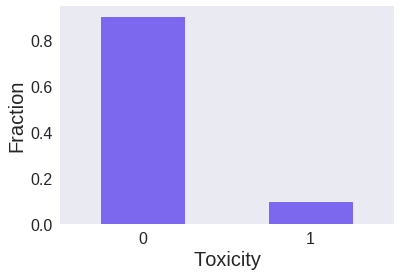

In [5]:
#@title
ax = train_data.toxic.value_counts(normalize=True).plot.bar(fontsize=16, rot=0, figsize=(6,4), 
                                                          color='mediumslateblue')
ax.set_xlabel("Toxicity", fontsize=20)
ax.set_ylabel("Fraction", fontsize=20);

From the top rows and the bar plot for the ratio of labels. One can find

- In total, there are more than 200000 training examples.

- The balance of the daset is around 90%. 

- The training set is mainly written in English.

### Validation set

In [6]:
#@title
print(f"Number of validation data: {val_data.shape[0]}")
val_data.head()

Number of validation data: 8000


,id,comment_text,lang,toxic
0,0,Este usuario ni siquiera llega al rango de ...,es,0
1,1,Il testo di questa voce pare esser scopiazzato...,it,0
2,2,Vale. Sólo expongo mi pasado. Todo tiempo pasa...,es,1
3,3,Bu maddenin alt başlığı olarak uluslararası i...,tr,0
4,4,Belçika nın şehirlerinin yanında ilçe ve belde...,tr,0


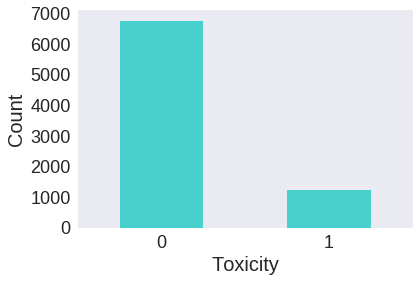

In [7]:
#@title
ax = val_data.toxic.value_counts().plot.bar(rot=0, fontsize=18,figsize=(6,4),  
                                      color='mediumturquoise')
ax.set_xlabel("Toxicity", fontsize=20)
ax.set_ylabel("Count", fontsize=20);

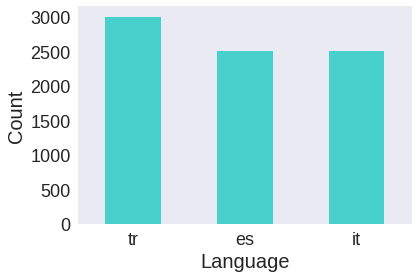

In [8]:
#@title
ax = val_data.lang.value_counts().plot.bar(rot=0, fontsize=18,figsize=(6,4),  
                                      color='mediumturquoise')
ax.set_xlabel("Language", fontsize=20)
ax.set_ylabel("Count", fontsize=20);

**Note**: 'tr' means Turkish, 'es' indicates Spanish, and 'it' is for Italian.

For the validation set

- There are 8000 points in the validation set.

- The comments are written in three other non-English languages.

- The validation set is also highly unbalanced, with a balance around 0.85.

### Test set

In [9]:
#@title
print(f"Number of test data: {test_data.shape[0]}")

Number of test data: 63812


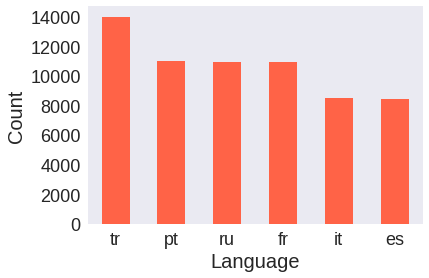

In [10]:
#@title
ax = test_data.lang.value_counts().plot.bar(rot=0, fontsize=18,figsize=(6,4),  
                                      color='tomato')
ax.set_xlabel("Language", fontsize=20)
ax.set_ylabel("Count", fontsize=20);

**Note**: 'pt' is Portuguese, 'ru' is Russian, and 'fr' is  French.

Regarding the test set

- It contains more than 60000 data. 

- The comments are written in even more non-English languages.

## 2.2 WordClound of Comments

The method for wordclounds is adapted from [this kernel](https://www.kaggle.com/tarunpaparaju/jigsaw-multilingual-toxicity-eda-models).

### All Comments in the training set

In [11]:
#@title
from wordcloud import WordCloud, STOPWORDS
stopword = set(STOPWORDS)

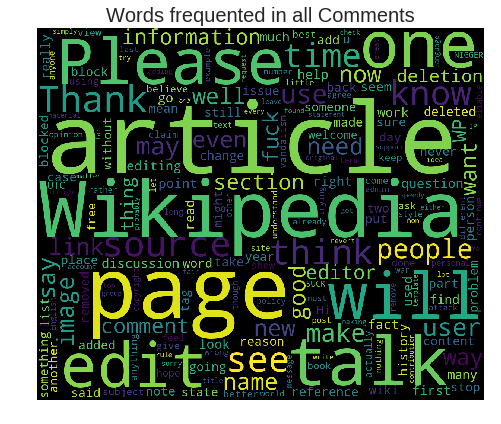

In [63]:
#@title
def nonan(x):
    if type(x) == str:
        return x.replace("\n", "")
    else:
        return ""
text = ' '.join([nonan(abstract) for abstract in train_data["comment_text"]])
# text = ' '.join([nonan(abstract) for abstract in val_data["comment_text"]])
wordcloud = WordCloud(max_font_size=None, background_color='black', collocations=False,
                      width=1200, height=1000).generate(text)
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Words frequented in all Comments", fontsize=20)
plt.imshow(wordcloud);

We can see that the most common words include "Wikipedia", "article", "will" and "see".

We also summarize the common words in the toxic comments in another worldclouds plot. 

**Disclaimer: The following figure contains text that may be considered profane, vulgar, or offensive.** 

###  Toxic Comments in the training set

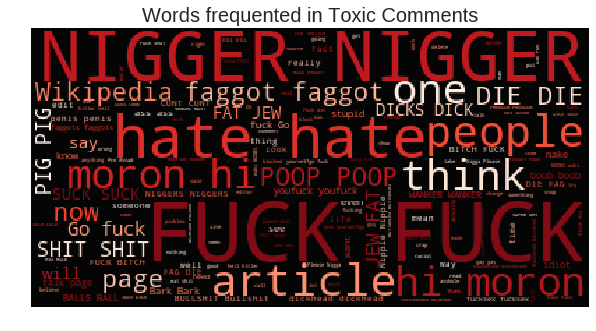

In [14]:
#@title
#Toxic comments
plt.figure(figsize=(10,10))
subset=train_data[train_data.toxic==1]
text=subset.comment_text.values
wc= WordCloud(background_color="black",max_words=2000,stopwords=stopword)
wc.generate(" ".join(text))
plt.axis("off")
plt.title("Words frequented in Toxic Comments", fontsize=20)
plt.imshow(wc.recolor(colormap= 'Reds' , random_state=244), alpha=0.98);

The toxic comments use more insulting or hateful words such as "Die" and "PIG".

###  Word count 

We will look at the number of words present in the comments.

#### Distribution of \# words of all comments

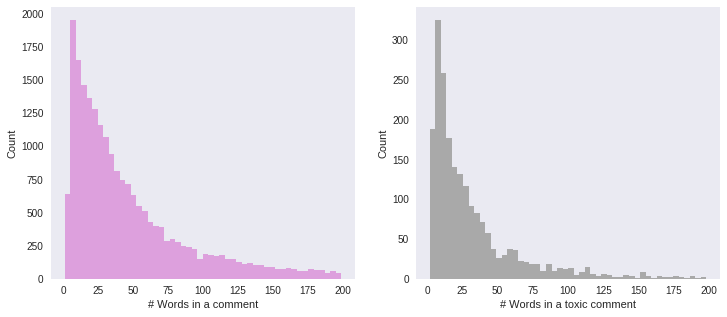

In [15]:
#@title
def new_len(x):
    if type(x) is str:
        return len(x.split())
    else:
        return 0

train_data["comment_words"] = train_data["comment_text"].apply(new_len)
nums = train_data.query("comment_words != 0 and comment_words < 200").sample(frac=0.1)["comment_words"]
plt.figure(figsize=(12,5))
plt.subplot(121)
plt.hist(nums, bins=50, color='plum')
plt.xlabel("# Words in a comment")
plt.ylabel("Count")

plt.subplot(122)
nums = train_data.query("comment_words != 0 and comment_words < 200 and toxic==1").sample(frac=0.1)["comment_words"]
plt.hist(nums, bins=50, color='darkgrey')
plt.xlabel("# Words in a toxic comment")
plt.ylabel("Count")
plt.show()

Both distributions are right skewed, with the maximum value centered at around 13 words per comment. Yet, it seems that the number of words in a toxic comment is shorter than that of a common comment.

###  Sentence count 

Next we will count the number of sentences in all comments and in toxic comments.

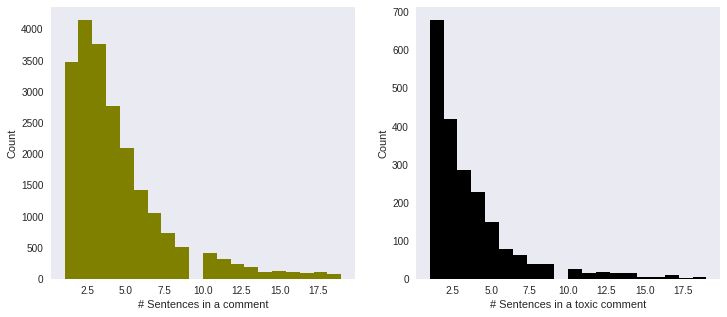

In [16]:
#@title
def new_len(x):
    if type(x) is str:
        return len(x.split('.'))
    else:
        return 0

train_data["comment_sentences"] = train_data["comment_text"].apply(new_len)
nums = train_data.query("comment_sentences != 0 and comment_sentences < 20 ").sample(frac=0.1)["comment_sentences"]
plt.figure(figsize=(12,5))
plt.subplot(121)
plt.hist(nums, bins=20, color='olive')
plt.xlabel("# Sentences in a comment")
plt.ylabel("Count")

plt.subplot(122)
nums = train_data.query("comment_sentences != 0 and comment_sentences < 20 and toxic==1").sample(frac=0.1)["comment_sentences"]
plt.hist(nums, bins=20, color='k')
plt.xlabel("# Sentences in a toxic comment")
plt.ylabel("Count")
plt.show()

Similar conclusions can be drawed when we compare the number of sentences in a comment and that in a toxic comment, that is, toxic comments tend to be shorter.

# 3. The Baseline Language Model

A language model is basically a machine learning model that looks at part of a sentence and is able to predict the next word, such as next word recommendation for cellphone keyboard typing. 

Statistically, a language model is a probability distribution over sequence of words. Most language models rely on the basic assumption that the probability of a word only depends on the previous *n* words, which is known as the *n*-gram model. The state-of-the-art language models, such BERT and XLM-RoBERTa, not only look at the previous  words, but also the words following it. In this sense, the context of word can be better represented.

In this section a baseline multilingual model will be introduced. It uses the pre-trained BERT, which is short for Bidirectional Encoder Representations from Transformer. The focus is to illustrate the important concepts in a language model, rather than the detailed implementations. 

For the demonstration of a BERT model, please  refer to [the colab notebook](https://colab.research.google.com/drive/1Pesk5LFMvDXQR0EqRzVRPIBBPNqNSEbT#scrollTo=8BSCrjLN2WSX). 

## 3.1 Data Preprocess

For a given sentence, there might exist some misspellings, or duplicate sentences or messy symbols. Therefore the first step is to clean the data.

The data cleaning pipeline of the function `clean_data` is adapted from [this kernel][1].

[1]: https://www.kaggle.com/mobassir/understanding-cross-lingual-models

Basically it cleans a comment text in three steps. 

1. Change the comment to lower cases, remove the duplicated sentences, delete line breakers, website ip addresses, and http website links.

2. Remove some punctuations such as "\*" and "►".

3. Check the typical misspellings and replace them with the correct expressions.

```python
def clean(text):
    text = text.lower()
    text = exclude_duplicate_sentences(text, lang='en')
    text = re.sub('\\n',' ', text)
    text = re.sub("\[\[User.*",'',text)
    text = re.sub("\d{1,3}\.\d{1,3}\.\d{1,3}\.\d{1,3}",'',text)
    text = re.sub("\(http://.*?\s\(http://.*\)",'',text)
    return text

def clean_text(x):
    x = str(x).replace("\n"," ")
    for punct in puncts:
        x = x.replace(punct, ' ')
    return x

def clean_data(df, columns: list):
    for col in columns:
        df[col] = df[col].apply(lambda x: clean(x))
        df[col] = df[col].apply(lambda x: clean_text(x)) 
        df[col] = df[col].apply(lambda x: replace_typical_misspell(x))  
    return df
```

## 3.2 The Journey of a Comment

The example detailed in [Jay's blog][1] is used to illustrate the journery of a comment text for a language model. Typically, a comment will undergo three sequential procedures. 

- It is divided to some tokens, and then the tokens are encoded to a vector. 
- Afterwards, the vectorized sequence is sent to a transformer for futhre exploitation of the contexts of the comment. 
- In the end, the output of the transformer is passed to a classifier for the purpose of sentiment analysis.

We elaborate the three steps separately. 

**Note**: all figures in this subsection are taken from [Jay's blog][1].

[1]:http://jalammar.github.io/a-visual-guide-to-using-bert-for-the-first-time/

### 3.2.1 Tokenizer

A tokenizer works as a pipeline. It processes some raw text as input and output encoding. It is usually structured into three steps. For instance, if we would like to classify the sentence "“a visually stunning rumination on love", the tokenizer will firstly split the sentences into words with some separator, say whitespace. In the next step, special tokens will be added for sentence classifications for some tokenizers. For example, [CLS] is added as the first position of a comment/review, and [SEP] is added at the end of each sentence. Note that a comment/review may consist of many sentences, therefore we could have many [SEP]s in one comment, but only one [CLS].

![Tokenization][1]

[1]:http://jalammar.github.io/images/distilBERT/bert-distilbert-tokenization-1.png

The final step is to replace each token with its numeric id from the embedding table, which is a natural component of a pre-trained model. Then the sentence is ready to be sent for a transformer to be processed.

![Embedding][1]

[1]:http://jalammar.github.io/images/distilBERT/bert-distilbert-tokenization-2-token-ids.png

### 3.2.2 Transformer

A transformer usually comprises of an encoder and a decoder. Encoders and decoders are intrinsically stacks of recurrent neural networks. As for BERT, it is made up by stacks of only encoders. When an embedded input sequence passes through the model, the output would be a vector for each input token, which is made up of 768 float numbers for a BERT model. As this is a sentence classification problem, we take out the first vector associated with the [CLS] token, which is also the one we send to the classifier. The illustrative figure in the following recaps the tokenization and transformation steps.

![Transformer][1]

[1]:http://jalammar.github.io/images/distilBERT/bert-input-to-output-tensor-recap.png

With the output of the transformer, we can slice the important hidden states for classification, which correspond to the first position token [CLS].

![Transformer][1]

[1]:http://jalammar.github.io/images/distilBERT/bert-output-tensor-selection.png

### 3.2.3 Classifier

For a multilingual model like BERT, the tokenization and transformation are realised in neural networks. So it would be straightforward to use neural network for the classification.
If we use a dense layer with only one output as the last layer, it behaves like a logistic regression classifier. Alternatively, we can add 
additional dense layers to add more flexibility for the classifier.

![LR][1]

[1]:http://jalammar.github.io/images/distilBERT/logistic-regression-dataset-features-labels.png

## 3.3 Model Evaluation

Since the dataset is highly skewed towards the non-toxic comments, ROC-AUC is used as the evaluation metric to represent the extent to which the comments are misclassified. Intuitively, the higher the AUC value, the less overlap the prediction for the two classes will be. In light of this characteristic of AUC metric, further separating the two classes distribution or reduce the variance of the prediction will be helpful to increase the AUC. 

The model is trained with 3-fold cross validation. The best model with lowest validation loss is chosen for the model evaluation. Firstly we evaluate the model by looking at its training history for `loss`.

![training history][1]

[1]:https://raw.githubusercontent.com/cengc13/2040FinalProject/master/src/screencast/training_history.png

It shows that the overall loss for both train and validation decreases gradually, although there is a bump from Epoch 5 to Epoch 6 for the validation loss.

Then we take a look at the prodicted probabilities for the comments in the validation set.

![prob][1]

[1]:https://raw.githubusercontent.com/cengc13/2040FinalProject/master/src/screencast/prob_dist.png

The distribution of predited probabilities for nontoxic and toxic comments indicate that

- The BERT multilingual model can identify the toxic comments for most cases. In other words, toxic and nontoxic comments are concentrated towards probability $1$ and $0$, respectively.

- However, there are a certain fraction of comments that are seriously misclassified, i.e. toxic comments are predicted to be of low probabilities and nontoxic comments enter the high probability region. 

The following plot studies the receiver operating characteristic of the classifier on the validation set.
The auc is close to 0.91. It is desirable for a classifier trained on highly unbalanced dataset.

However, 0.91 auc score is not good enough to secure a medal for this Kaggle competition.  We need a score about 0.946 to arrive at the metal region on the leaderboard. 

In the next section, we will discuss some teniques to further improve the model performance.

![roc_auc][1]

[1]:https://raw.githubusercontent.com/cengc13/2040FinalProject/master/src/screencast/roc-auc.png

# 4. Model Refinement

There are mainly three significant challenges regarding this competition that one needs to take care of. In order to refine the baseline model, we should carefully circumvent or mitigate those issues.

- **Data Size Issue**: the training dataset consists of more than 200,000 data, which thus requires a huge amount of time to clean and pre-process the data. In addition, a common multi lingual model has more than 100 millions parameters. For such a large number of data size and model parameters, even training on TPU can be computationally intensive. 

- **Unbalance Issue**: the training and validation set is highly unbalanced with a toxic/nontoxic ratio around 1:9. Therefore, this competition uses the ROC-AUC value as the evaluation metric. In other words, if we train the model based on the unbalanced dataset, the model is more likely to predict better on nontoxic comments than toxic ones.

- **Multilingual Issue**: the training set is written in English. The validation is given in three languages, including Turkish, Spanish and Italian. Besides the multilingual validation set, the testing set is written in three more types of languages, including Russian, French and Portuguese. 

## 4.1 Increase the input size

The maximum length for the input vector sequence is adjusted. I tried lengths of 150, 192, 210, and 224. 224 maximum length gives the best LB score of 0.9378.

## 4.2 Hyperparameter Tuning

The hyperparameter tuning aims to the resolve the "Data Size Issue" and "Unbalance Issue". However, not all hyperparameters involved are taken into account. Instead, attention is paid to those that we think are significant.

- Change the data size of training set. Only a fraction of the training data corresponding to non-toxic comments is selected. It was found that sub-sampling the non-toxic comments help a lot in balancing the dataset. It increases the LB score to 0.9401 with the best maximum length.

- Tweak the loss function. The most typical loss function for a binary classification problem is the `binary_crossentropy` as implemented in `Tensorflow`. Yet, a great work by [Lin et.al](https://arxiv.org/pdf/1708.02002.pdf) proves that a novel loss they term "Focal Loss" that adds a pre-factor to the standard cross entropy criterion can boost the model accuracy. The name "focal" comes from the fact that the model now pays less attention to the well classified samples while putting more focus on hard, misclassified examples. A weighting factor is also introduced to mitigate the class unbalance issue. The figure below shows why Focal loss focuses more on the misclassified data. Unfortunately, models with focal loss perform similarly compared to the standard binary cross entropy.

![focal_loss][1]


[1]:https://raw.githubusercontent.com/cengc13/2040FinalProject/master/src/screencast/focal_loss.png

- Other random efforts. 
    * An additional dense layer and a dropout layer right ahead of the final layer is added. Then the dropout rate and the number of neurons in the dense layer are tuned. Although the model does not improve a lot in terms of the validation accuracy and the LB score, we believe that it would be more accurate  on unseen data because adding regularization into a model will increase its generalization capability. 
    * I also tried a learning rate scheduler. However, no significant improvement was observed.

## 4.3 Data Augmentation

This strategy is of central importance as in the training data we only have English-written comments while in the validation and test set, we have comments written in other languages. Although the multilingual model can capture some of the shared knowledge between various languages, data augmentation is necessary to improve the model performance. As of now, two approaches are tested. 

- Translate the training set to other languages and keep the validation and test set unchanged. This approach gives me a best LB score of 0.9365.

- Translate the validation and test set to English. This model performs slightly better, with a LB score of 0.9378.

## 4.4 Model Architectures

The model architecture is mainly associated with the **Multilingual Issue**. Since models with various architectures are pre-trained on varying size dataset or/and targeted on its unique semi-unsupervised tasks, their capability of learning cross-lingual knowledge is distinct.

The baseline BERT model performs satisfactorily on the multilingual task, with which the public LB score is 0.916. As we mentioned in [the second blog][1], the most successful multilingual model is probably the XLM-RoBERTa model, especially the large XLM-R model. The large XLM-R model has more than 500 million parameters, and it demonstrates to be superior to other language models in multilingual modeling. With XLM-R architecture, our baseline LB score goes up to 0.9365, a significant improvement compared to the baseline BERT model.

[1]:https://cengc13.github.io/final-project-midway-blog/

## 4.5 Ensemble Prediction

I did ensemble prediction by weighting four best models. The LB score for individual models are 0.9427, 0.9416, 0.9401 and 0.9365, respectively. By carefully tuning the weights, I arrived at a LB score of 0.9453.

Further combining my own best submission with public top-score submissions, I am able to achieve a Public LB score of 0.9477, which leads to a top 5% position out of more than 900 teams. The following snapshot is the latest ranking on the public leaderboard.

![public leaderboard][1]

[1]:https://raw.githubusercontent.com/cengc13/2040FinalProject/master/src/screencast/public_lb.png

# 5. Next Steps

- Metric learning: post-process the prediction to further improve the ranking on the leaderboard.

- Other NLP augmentation schemes. There are some awesome NLP augmentation methods implemented in the open-source package [albumentation][1]

- Apply the model to do transfer learning, such as predicting the status of a reddit post, which can either be upvote or downvote/removed. Or predicting the sentiment on the dataset for another Kaggle competition ["tweet sentiment extraction"](https://www.kaggle.com/c/tweet-sentiment-extraction).

![nlp augmentation][2]

![nlp augmentation][3]

[1]:https://raw.githubusercontent.com/cengc13/2040FinalProject/master/src/screencast/public_lb.png
[2]:https://raw.githubusercontent.com/cengc13/2040FinalProject/master/src/screencast/nlp_aug_swap.png
[3]:https://raw.githubusercontent.com/cengc13/2040FinalProject/master/src/screencast/nlp_aug_cutout.png

# 6. Acknowledgement

**Note**: For all contents in this notebook I already use the in-place citations.

Honestly this is my first NLP project. I chose a project on Kaggle because the Kaggle community is an awesome place to share and learn machine learning knowledge. I would like to thank all those great participants on Kaggle, who make this learning process so rewarding and enjoyable. Special thanks to wonderful kernels on Kaggle and blogs by Jay:

- [EDA and Modeling Kernel](https://www.kaggle.com/tarunpaparaju/jigsaw-multilingual-toxicity-eda-models) ~ by Tarun Paparaju

- [Framework for the XLM-R model](https://www.kaggle.com/xhlulu/jigsaw-tpu-xlm-roberta) ~ by xululu

- [Illustrative Attention](https://jalammar.github.io/visualizing-neural-machine-translation-mechanics-of-seq2seq-models-with-attention/) ~ by Jay Alammer

- [Github blog template](https://github.com/barryclark/jekyll-now) ~ by Barry Clark

- [Data cleaning](https://www.kaggle.com/mobassir/understanding-cross-lingual-models) ~ by mobassir

- [K-Fold Cross-validation on TPU](https://www.kaggle.com/shahules/fine-tune-xlm-kfold-cv-0-93-lb) ~ by shahules

I am also grateful to the instructors of DATA2040, who allows me to choose this interesting final project, and gave me constructive suggestions at the checkpoint meetings. 